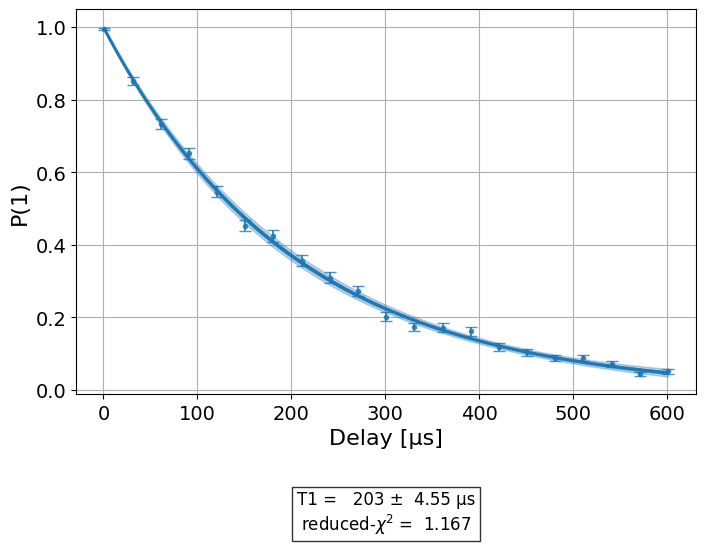

AnalysisResult
- name: @Parameters_T1Analysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_exp_decay(x) = amp * exp(-x/tau) + base
 - success: True
 - number of function evals: 16
 - degree of freedom: 18
 - chi-square: 21.004598340329405
 - reduced chi-square: 1.1669221300183004
 - Akaike info crit.: 6.004597836956844
 - Bayesian info crit.: 9.138165150127113
 - init params:
  * amp = 0.9512195121951219
  * tau = 0.00019768173260363767
  * base = 0.04341463414634146
 - fit params:
  * amp = 1.0047077652457097 ± 0.006729413878679666
  * tau = 0.00020321481991540733 ± 4.550205192855672e-06
  * base = -0.005328068310344074 ± 0.006666485171613017
 - correlations:
  * (amp, base) = -0.9422896942722354
  * (tau, base) = -0.9018358474770432
  * (amp, tau) = 0.8179914045292583
- quality: good
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: T1
- value: 0.000203+/-0.000005
- χ²: 1.1669221300183004
- quality: good
- extra: <1 ite

In [1]:
import numpy as np
from qiskit.qobj.utils import MeasLevel
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import T1
from qiskit_experiments.library.characterization.analysis.t1_analysis import T1KerneledAnalysis

# A T1 simulator
from qiskit.providers.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

# A kerneled data simulator
from qiskit_experiments.test.mock_iq_backend import MockIQBackend
from qiskit_experiments.test.mock_iq_helpers import MockIQT1Helper

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Look up target T1 of qubit-0 from device properties
qubit0_t1 = FakePerth().qubit_properties(0).t1

# Time intervals to wait before measurement
delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)
# Create an experiment for qubit 0
# with the specified time intervals
exp = T1(physical_qubits=(0,), delays=delays)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp.set_transpile_options(scheduling_method='asap')

# Run the experiment circuits and analyze the result
exp_data = exp.run(backend=backend, seed_simulator=101).block_for_results()

# Print the result
display(exp_data.figure(0))
for result in exp_data.analysis_results():
    print(result)

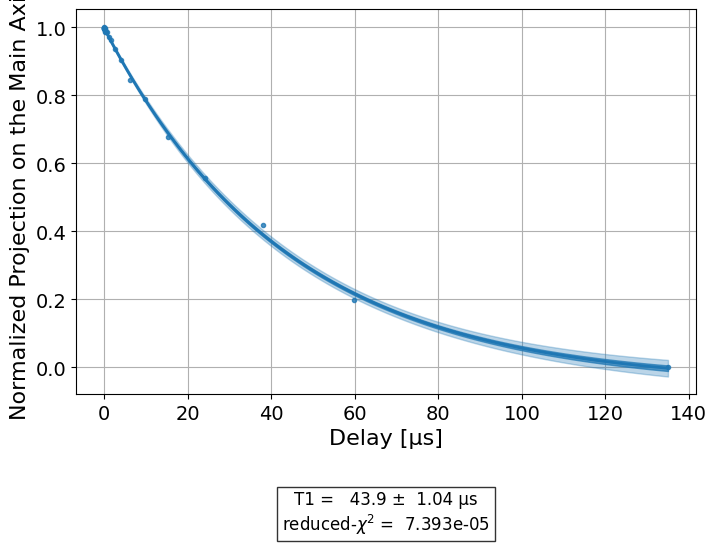

AnalysisResult
- name: @Parameters_T1KerneledAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_exp_decay(x) = amp * exp(-x/tau) + base
 - success: True
 - number of function evals: 24
 - degree of freedom: 22
 - chi-square: 0.0016265491601968527
 - reduced chi-square: 7.393405273622057e-05
 - Akaike info crit.: -235.00426032116383
 - Bayesian info crit.: -231.34763284655924
 - init params:
  * amp = 1.0
  * tau = 4.95e-05
  * base = 0.0
 - fit params:
  * amp = 1.0469535438058768 ± 0.011310466790627725
  * tau = 4.3944154522802436e-05 ± 1.035755539157802e-06
  * base = -0.05146921070703622 ± 0.011431939562564896
 - correlations:
  * (amp, base) = -0.9835183492471947
  * (tau, base) = -0.8493160599815903
  * (amp, tau) = 0.8027246618380921
- quality: good
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: T1
- value: (4.39+/-0.10)e-05
- χ²: 7.393405273622057e-05
- quality: good
- extra: <1 items>
- device_components: ['

In [2]:
# Experiment
ns = 1e-9
mu = 1e-6

# qubit properties
t1 = [45 * mu, 45 * mu]
t2 = [value/2 for value in t1]

# we will guess that our guess is 10% off the exact value of t1 for qubit 0.
t1_estimated_shift = t1[0]/10

# We use log space for the delays because of the noise properties
delays = np.logspace(1, 11, num=23, base=np.exp(1))
delays *= ns

# Adding circuits with delay=0 and long delays so the centers in the IQ plane won't be misplaced.
# Without this, the fitting can provide wrong results.
delays = np.insert(delays, 0, 0)
delays = np.append(delays, [t1[0]*3])

num_qubits = 2
num_shots = 2048

backend = MockIQBackend(
    MockIQT1Helper(t1=t1, iq_cluster_centers=[((-5.0, -4.0), (-5.0, 4.0)), ((3.0, 1.0), (5.0, -3.0))]
                       , iq_cluster_width=[1.0, 2.0])
)

# Creating a T1 experiment
expT1_kerneled = T1((0,), delays)
expT1_kerneled.analysis = T1KerneledAnalysis()
expT1_kerneled.analysis.set_options(p0={"amp": 1, "tau": t1[0] + t1_estimated_shift, "base": 0})

# Running the experiment
expdataT1_kerneled = expT1_kerneled.run(backend=backend, meas_return="avg",
                                        meas_level=MeasLevel.KERNELED,
                                        shots=num_shots).block_for_results()

# Displaying results
display(expdataT1_kerneled.figure(0))
for result in expdataT1_kerneled.analysis_results():
    print(result)